<br/>

$$ \huge{\underline{\textbf{ On-Policy First-Visit MC Control }}} $$

<br/>

<center>Implementation of <b>On-Policy First-Visit MC Control</b></center>
<center>from Sutton and Barto 2018, <b>chapter 5.4</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/0504_OnPolicy_MC_Ctrl.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 5.4 </center>

<br/>

Implementation below is meant to correspond to the box as close as possible. For normal uses see alternative implementation below.

In [1]:
def on_policy_MC_control(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor
        eps - epsilon-greedy parameter
    """
    
    def policy(St, pi):
        return np.random.choice(env.act_space, p=[pi[(St,a)] for a in env.act_space])
    
    pi = defaultdict(lambda: 1/env.nb_actions)  # probability of action (def random)
    Q = defaultdict(float)       # default Q value: 0
    Returns = defaultdict(list)  # dict of lists
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, pi)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
                Returns[(St, At)].append(G)
                Q[(St, At)] = np.average(Returns[(St, At)])
                A_star = argmax_rand([Q[(St,a)] for a in range(env.nb_actions)])  # int
                for a in range(env.nb_actions):
                    if a == A_star:   pi[(St,a)] = 1 - eps + eps/env.nb_actions
                    else:             pi[(St,a)] = eps/env.nb_actions
                        
    return Q, pi

Helper Functions:

In [2]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St, *params)        
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [3]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

# Alternative Implementation

This implementation is meant for normal use. Main changes:
* no need to keep every-single-return-ever in long list - just keep sum and counter for each state-action pair.
* no need to express policy explicitly in this case - *pi* dictionary removed

In [4]:
def on_policy_MC_control_2(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep [int] - number of episodes to run
        gamma [float] - discount factor
        eps [float] - epsilon-greedy parameter
    """
    
    def policy(St, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[(St,a)] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)        # default Q value: 0
    Counts = defaultdict(int)
    Returns = defaultdict(float)  # stores SUM
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, Q, eps)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            # Do away with first-visit check
            # if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
            Counts[(St, At)]  += 1
            Returns[(St, At)] += G
            Q[(St, At)] = Returns[(St, At)] / Counts[(St, At)]
                                    
    return Q

# Solve Blackjack

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym

Create environment

In [6]:
env = gym.make('Blackjack-v0')
if not hasattr(env, 'nb_actions'): env.nb_actions = 2
if not hasattr(env, 'act_space'): env.act_space = [0, 1]

Plotting, boring

In [7]:
from helpers_0504 import plot_blackjack

Run

In [8]:
# Q, _ = on_policy_MC_control(env, ep=1000000, gamma=1.0, eps=0.1)  # +5min ??
# plot_blackjack(Q)

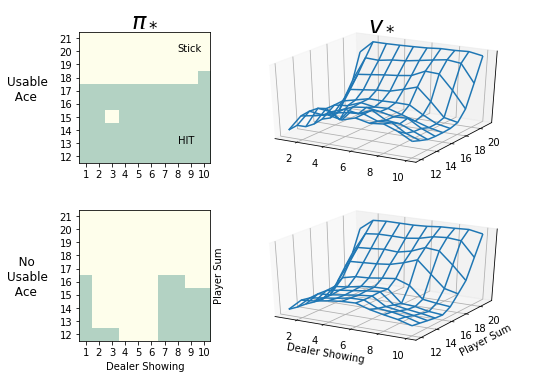

In [9]:
Q = on_policy_MC_control_2(env, ep=1000000, gamma=1.0, eps=0.1)  # ~2-3min?
plot_blackjack(Q)